## Motivations
Testing out code for longitudinal anisotropy 1D


In [27]:
import sys
sys.path.append('D:\\RCWA\\')

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond
import cmath;
from scipy import linalg as LA
from numpy.linalg import solve as bslash
import time
from convolution_matrices.convmat1D import *
from RCWA_1D_functions.grating_fft.grating_conv import *

def nonHermitianEigenSorter(eigenvalues):
    N = len(eigenvalues);
    sorted_indices=[];
    sorted_eigs = [];
    for i in range(N):
        eig = eigenvalues[i];
        if(np.real(eig)>0 and np.imag(eig) == 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)==0 and np.imag(eig) > 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)>0 and abs(np.imag(eig)) > 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
    return sorted_eigs, sorted_indices;

# Moharam et. al Formulation for stable and efficient implementation for RCWA
plt.close("all")
'''
1D TM implementation of PLANAR DIFFRACTiON
STILL NOT WORKING YET

only: sign convention is exp(-ikr) (is the positive propagating wave), so loss is +  not - 
source for fourier decomps is from the paper: Formulation for stable and efficient implementation of
the rigorous coupled-wave analysis of binary gratings by Moharam et. al
'''

# plt.plot(x, np.real(fourier_reconstruction(x, period, 1000, 1,np.sqrt(12), fill_factor = 0.1)));
# plt.title('check that the analytic fourier series works')
# #'note that the lattice constant tells you the length of the ridge'
# plt.show()

L0 = 1e-6;
e0 = 8.854e-12;
mu0 = 4*np.pi*1e-8;
fill_factor = 0.3; # 50% of the unit cell is the ridge material

num_ord = 3; #INCREASING NUMBER OF ORDERS SEEMS TO CAUSE THIS THING TO FAIL, to many orders induce evanescence...particularly

               # when there is a small fill factor
PQ = 2*num_ord+1;
indices = np.arange(-num_ord, num_ord+1)

n_ridge = 3.48;              # ridge
n_groove = 3.48;                # groove (unit-less)
lattice_constant = 0.7;  # SI units
# we need to be careful about what lattice constant means
# in the gaylord paper, lattice constant exactly means (0, L) is one unit cell


d = 0.46;               # thickness, SI units
Nx = 2*256;
eps_r = n_groove**2*np.ones((2*Nx, 1)); #put in a lot of points in eps_r
eps_xz = np.zeros((2*Nx,1));
border = int(2*Nx*fill_factor);
eps_r[0:border] = n_ridge**2;
eps_xz[0:border] = 0.5;
#eps_xz[:] =12 ;
eps_zx = eps_xz;

fft_fourier_array = grating_fft(eps_r);
x = np.linspace(-lattice_constant,lattice_constant,1000);
period = lattice_constant;

## simulation parameters
theta = (0)*np.pi/180;



In [28]:
## construct permittivity harmonic components E
#fill factor = 0 is complete dielectric, 1 is air

##construct convolution matrix
Ezz = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); Ezz = Ezz.astype('complex')
p0 = Nx; #int(Nx/2);
p_index = np.arange(-num_ord, num_ord + 1);
q_index = np.arange(-num_ord, num_ord + 1);
fourier_array = fft_fourier_array;#fourier_array_analytic;
detected_pffts = np.zeros_like(Ezz);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        Ezz[prow, pcol] = fourier_array[p0 + pfft];  # fill conv matrix from top left to top right

# Exz = np.zeros_like(Ezz);
# Ezx = np.zeros_like(Ezz);
# Exz = 2*np.eye(PQ)
# Ezx = Exz;
# print((Exz.shape, Ezx.shape, Ezz.shape))

## FFT of 1/e;
inv_fft_fourier_array = grating_fft(1/eps_r);
##construct convolution matrix
E_conv_inv = np.zeros((2 * num_ord + 1, 2 * num_ord + 1));
E_conv_inv = E_conv_inv.astype('complex')
p0 = Nx;
p_index = np.arange(-num_ord, num_ord + 1);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        E_conv_inv[prow, pcol] = inv_fft_fourier_array[p0 + pfft];  # fill conv matrix from top left to top right


In [29]:
## specialized fourier matrices for exz

exzzxzz = eps_xz*eps_zx/eps_r;
exzzz = eps_xz/eps_r;
ezxzz = eps_zx/eps_r;

be = 1/(eps_r - eps_xz*eps_zx/eps_r);
# plt.figure();
# plt.plot(exzzxzz) #verify anisotropy is localized
# plt.plot(exzzz )
# plt.plot(ezxzz)
# plt.show()

Exzzxzz = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); Exzzxzz  = Exzzxzz.astype('complex')
Exzzz = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); Exzzz  = Exzzz.astype('complex')
bEr = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); bEr  = bEr.astype('complex')

fourier_array_be = grating_fft(be);
fourier_array_xzzx = grating_fft(exzzxzz);
fourier_array_xzzz = grating_fft(exzzz);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        Exzzxzz[prow, pcol] = fourier_array_xzzx[p0 + pfft];  # fill conv matrix from top left to top right

for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        Exzzz[prow, pcol] = fourier_array_xzzx[p0 + pfft];  # fill conv matrix from top left to top right
        
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        bEr[prow, pcol] = fourier_array_be[p0 + pfft];  # fill conv matrix from top left to top right
Ezxzz = Exzzz

In [33]:
## IMPORTANT TO NOTE: the indices for everything beyond this points are indexed from -num_ord to num_ord+1
## alternate construction of 1D convolution matrix

PQ =2*num_ord+1;
I = np.eye(PQ)
zeros = np.zeros((PQ, PQ))
# E is now the convolution of fourier amplitudes
wavelength_scan = np.linspace(0.5, 4, 300)
spectra = list();
spectra_T = list();
for wvlen in wavelength_scan:
    j = cmath.sqrt(-1);
    lam0 = wvlen;     k0 = 2 * np.pi / lam0; #free space wavelength in SI units
    print('wavelength: ' + str(wvlen));
    ## =====================STRUCTURE======================##

    ## Region I: reflected region (half space)
    n1 = 1;#cmath.sqrt(-1)*1e-12; #apparently small complex perturbations are bad in Region 1, these shouldn't be necessary

    ## Region 2; transmitted region
    n2 = 1;

    #from the kx_components given the indices and wvln
    kx_array = k0*(n1*np.sin(theta) + indices*(lam0 / lattice_constant)); #0 is one of them, k0*lam0 = 2*pi
    k_xi = kx_array;
    ## IMPLEMENT SCALING: these are the fourier orders of the x-direction decomposition.
    KX = np.diag((k_xi/k0)); #singular since we have a n=0, m= 0 order and incidence is normal

    ## one thing that isn't obvious is that are we doing element by element division or is it matricial
    B = (KX@bslash(Ezz, KX) - I);
    
    
    ## SIGN MISMATCH WITH DERIVATION, first term should be positive but in the notes ,it's negative: FIX (3/4/2019)
    #bE = np.linalg.inv(E_conv_inv) - Exzzxzz #bslash(Ezz,(Exz@Ezx)); #/Ezz;
    bE = np.linalg.inv(bEr);
    
    G = j* Ezxzz @ KX#j*bslash(Ezz,Ezx) @ KX;
    #G = j*(Ezx/Ezz)@KX #we should not do pointwise division of these epsilon matrices.
    H = -j*KX @Exzzz; #j*KX @bslash(Ezz, Exz);
    #print((bE.shape,G.shape, H.shape))
    print('conditioning of B and bE: '+str((np.linalg.cond(B), np.linalg.cond(bE))))
    print('conditioning of G and H: '+str((np.linalg.cond(G), np.linalg.cond(H))))
    bigBlock = np.block([[G, bE],[B,H]]);
    print('conditioning of main block: '+str(np.linalg.cond(bigBlock)))

    ## these matrices aren't poorly conditioned
    print('conditioning of eigenvalue prob: '+str((np.linalg.cond(OA), np.linalg.cond(OB))))
    ## solve eiegenvalues;
    beigenvals, bigW = LA.eig(bigBlock); #W contains eigenmodes of the form (lambda x, x)

    ## AT THIS POINT, we have still extracted TWO times the number of eigenvalues...
    #try rounding...
    rounded_beigenvals = np.array([round(i,10) for i in beigenvals])
    print(rounded_beigenvals)
    #quadrant_sort = [1 if abs(np.real(i))>=0 and np.imag(i)>=0 else 0 for i in rounded_beigenvals];

    sorted_eigs, sorted_indices = nonHermitianEigenSorter(rounded_beigenvals)
    # sorted_indices = np.nonzero(quadrant_sort)[0]
    print(len(sorted_indices))
    #sorted_indices = np.argsort(np.real(rounded_beigenvals))
    sorted_eigenmodes = bigW[:, sorted_indices];
    #print(sorted_eigenmodes)
    #adding real and imaginary parts seems to work...
    sorted_eigenvals = beigenvals[sorted_indices]
    print(sorted_eigenvals)
    W = sorted_eigenmodes[0:PQ,:]

    eigenvals_wp = (sorted_eigenvals[0:PQ]);


#     plt.plot(np.real(beigenvals), np.imag(beigenvals), '.', markersize = 20);
#     plt.plot(np.real(eigenvals_wp), (np.imag(eigenvals_wp)), '.r', markersize = 10)
#     plt.legend(('original', 'sorted'))
#     plt.show();
    ##
    Q = np.diag(eigenvals_wp); #eigenvalue problem is for kz, not kz^2

    ## IS THIS RIGHT? #Q is a diagonal matrix of eigenvalues. W contains modes in columns... we want to column scale
    # so Q should be on the RHS of W.
    #V = np.linalg.inv(bE)@(W @ Q +  H@W);
    V = sorted_eigenmodes[PQ:,:]
    #enforcing negative sign convention.
    X = np.diag(np.exp(-k0*np.diag(Q)*d)); #this is poorly conditioned because exponentiation
    ## pointwise exponentiation vs exponentiating a matrix

    ## observation: almost everything beyond this point is worse conditioned
    k_I = k0**2*(n1**2 - (k_xi/k0)**2);                 #k_z in reflected region k_I,zi
    k_II = k0**2*(n2**2 - (k_xi/k0)**2);   #k_z in transmitted region
    ## are these formulas correct, as they only pertain teo the reflected and transmitted regions.
    
    k_I = k_I.astype('complex'); k_I = np.sqrt(k_I);
    k_II = k_II.astype('complex'); k_II = np.sqrt(k_II);
    Z_I = np.diag(k_I / (n1**2 * k0 ));
    Z_II = np.diag(k_II /(n2**2 * k0));
    delta_i0 = np.zeros((len(kx_array),1));
    delta_i0[num_ord] = 1;
    n_delta_i0 = delta_i0*j*np.cos(theta)/n1;
    
    O = np.block([
        [W, W],
        [V,-V]
    ]); #this is much better conditioned than S..
    print('condition of O: '+str(np.linalg.cond(O)))
    print((np.linalg.cond(W), np.linalg.cond(V)))
    # plt.imshow(abs(O))
    # plt.show();
    f = I;
    g = j * Z_II; #all matrices
    fg = np.concatenate((f,g),axis = 0)
    ab = np.matmul(np.linalg.inv(O),fg);
    a = ab[0:PQ,:];
    b = ab[PQ:,:];

    term = X @ a @ np.linalg.inv(b) @ X;
    f = W @ (I + term);
    g = V@(-I+term);
    
    
    ## does this change?, I think it might...
    T = np.linalg.inv(np.matmul(j*Z_I, f) + g);
    T = np.dot(T, (np.dot(j*Z_I, delta_i0) + n_delta_i0));
    R = np.dot(f,T)-delta_i0; #shouldn't change
    T = np.dot(np.matmul(np.linalg.inv(b),X),T)

    ## calculate diffraction efficiencies
    #I would expect this number to be real...
    DE_ri = R*np.conj(R)*np.real(np.expand_dims(k_I,1))/(k0*n1*np.cos(theta));
    DE_ti = T*np.conj(T)*np.real(np.expand_dims(k_II,1)/n2**2)/(k0*np.cos(theta)/n1);

    print('R(lam)='+str(np.sum(DE_ri))+' T(lam) = '+str(np.sum(DE_ti)))
    spectra.append(np.sum(DE_ri)); #spectra_T.append(T);
    spectra_T.append(np.sum(DE_ti))



wavelength: 0.5
conditioning of B and bE: (1.6107332707942463, 1.00168677515701)
conditioning of G and H: (1.4729122928958623e+18, 2.2551825860316815e+18)
conditioning of main block: 19.506030744972577
conditioning of eigenvalue prob: (12.110399993865716, 24.47849943481153)
[-0.00139385+2.74139351j  0.00139385+2.74139351j -0.        +3.47899559j
 -0.00221736+3.40505458j  0.00221736+3.40505458j -0.00135244+3.17249204j
  0.00135244+3.17249204j  0.00139385-2.74139351j -0.00139385-2.74139351j
  0.00135244-3.17249204j -0.00135244-3.17249204j -0.        -3.47899559j
  0.00221736-3.40505458j -0.00221736-3.40505458j]
7
[ 1.39385184e-03+2.74139351j -2.48521827e-15+3.47899559j
  2.21736400e-03+3.40505458j  1.35244472e-03+3.17249204j
  1.39385184e-03-2.74139351j  1.35244472e-03-3.17249204j
  2.21736400e-03-3.40505458j]
condition of O: 127.68736832212346
(24.953677947564422, 35.266285033838166)
R(lam)=(0.749998716153547+0j) T(lam) = (0.32793725102796806+0j)
wavelength: 0.5117056856187291
condition

condition of O: 1136.5961506931712
(62.73533807964301, 288.864195083901)
R(lam)=(0.13763795227955822+0j) T(lam) = (0.8408152299595864+0j)
wavelength: 1.0501672240802675
conditioning of B and bE: (3.8971105744377166, 1.00168677515701)
conditioning of G and H: (1.373086542626364e+18, 2.446566763140236e+18)
conditioning of main block: 47.18232291923711
conditioning of eigenvalue prob: (12.110399993865716, 24.47849943481153)
[ 2.85606267-0.j          2.85023214-0.j         -2.85606267-0.j
 -2.85023214-0.j          0.        -3.47897996j -0.00468717-3.13926353j
  0.00468717-3.13926353j  0.00288556-1.76264702j -0.00288556-1.76264702j
  0.        +3.47897996j -0.00468717+3.13926353j  0.00468717+3.13926353j
  0.00288556+1.76264702j -0.00288556+1.76264702j]
7
[2.85606267e+00-8.35038961e-17j 2.85023214e+00-1.05229444e-16j
 4.68717492e-03-3.13926353e+00j 2.88556105e-03-1.76264702e+00j
 1.01617924e-15+3.47897996e+00j 4.68717492e-03+3.13926353e+00j
 2.88556105e-03+1.76264702e+00j]
condition of O: 1

R(lam)=(0.17002254346129592+0j) T(lam) = (0.8267289509391766+0j)
wavelength: 1.5418060200668895
conditioning of B and bE: (4.346555984400957, 1.00168677515701)
conditioning of G and H: (8.247328814908379e+17, 2.7968585507616896e+18)
conditioning of main block: 20.203403595323234
conditioning of eigenvalue prob: (12.110399993865716, 24.47849943481153)
[-5.61969259+0.j         -5.61114124+0.j          5.61969259-0.j
  5.61114124-0.j          0.        -3.47897748j -2.69561876-0.j
 -2.70411289+0.j         -0.00688754-2.69368101j  0.00688754-2.69368101j
  2.69561876+0.j          2.70411289-0.j         -0.        +3.47897748j
 -0.00688754+2.69368101j  0.00688754+2.69368101j]
7
[ 5.61969259e+00-1.93575218e-15j  5.61114124e+00-1.84440674e-15j
  6.88753546e-03-2.69368101e+00j  2.69561876e+00+1.23937011e-16j
  2.70411289e+00-2.92609742e-16j -1.30456172e-15+3.47897748e+00j
  6.88753546e-03+2.69368101e+00j]
condition of O: 163.1748147823531
(30.67604639563352, 49.77301326116776)
R(lam)=(0.1239108

conditioning of main block: 34.54883430572502
conditioning of eigenvalue prob: (12.110399993865716, 24.47849943481153)
[-7.66354942+0.j         -7.65266407+0.j          7.66354942+0.j
  7.65266407+0.j         -4.3922334 +0.j         -4.40305779+0.j
  4.3922334 -0.j          4.40305779-0.j          0.        -3.47897666j
 -0.00877199-2.05995163j  0.00877199-2.05995163j  0.        +3.47897666j
  0.00877199+2.05995163j -0.00877199+2.05995163j]
7
[7.66354942e+00+2.17029991e-15j 7.65266407e+00+2.24594418e-15j
 4.39223340e+00-2.64573887e-16j 4.40305779e+00-1.32604288e-15j
 8.77198726e-03-2.05995163e+00j 1.77913175e-15+3.47897666e+00j
 8.77198726e-03+2.05995163e+00j]
condition of O: 369.9253338831878
(41.121558972044866, 141.90947736464662)
R(lam)=(0.5938850548722865+0j) T(lam) = (0.28876856851074234+0j)
wavelength: 1.9749163879598661
conditioning of B and bE: (14.341891324598832, 1.00168677515701)
conditioning of G and H: (4.910479473956639e+17, 1.226792536240423e+18)
conditioning of main bl

 -0.56263086+0.j         -0.54052913+0.j        ]
7
[9.98566119e+00-2.95417987e-16j 9.97198731e+00+2.15127734e-16j
 6.11935108e+00-7.88667979e-16j 6.13295715e+00+2.80593754e-16j
 1.20487872e-15+3.47897618e+00j 5.62630862e-01-7.39783434e-16j
 5.40529132e-01-4.27660140e-16j]
condition of O: 21.966242901601937
(1.296168107834766, 13.97234652371722)
R(lam)=(0.6223637258597703+0j) T(lam) = (0.37751970075705316+0j)
wavelength: 2.4782608695652173
conditioning of B and bE: (237.58510051262252, 1.00168677515701)
conditioning of G and H: (5.310548685189519e+17, 8.207029616291951e+17)
conditioning of main block: 347.93278125981885
conditioning of eigenvalue prob: (12.110399993865716, 24.47849943481153)
[-10.0387922 +0.j         -10.02505346+0.j
  10.0387922 +0.j          10.02505346-0.j
  -6.15773963+0.j          -6.17141038+0.j
   6.15773963-0.j           6.17141038-0.j
  -0.        -3.47897617j   0.        +3.47897617j
  -0.6609394 -0.j          -0.63874736+0.j
   0.6609394 -0.j           0.638

  -2.44175694-0.j          -2.46841644-0.j        ]
7
[ 1.23000405e+01-2.15800786e-15j  1.22835129e+01-2.14478038e-15j
  7.76496453e+00-3.79911815e-16j  7.78141599e+00-4.20625599e-16j
 -9.24652796e-16+3.47897592e+00j  2.46841644e+00+4.08378575e-16j
  2.44175694e+00+2.22427168e-16j]
condition of O: 4.934658298517659
(1.3979566824903562, 3.5848621246562025)
R(lam)=(0.11758487622481331+0j) T(lam) = (0.8823520963266003+0j)
wavelength: 2.9933110367892977
conditioning of B and bE: (24.689250195751338, 1.00168677515701)
conditioning of G and H: (1.4117379657996823e+18, 1.5311836171005094e+18)
conditioning of main block: 24.769052782780037
conditioning of eigenvalue prob: (12.110399993865716, 24.47849943481153)
[-12.35218805-0.j         -12.33559553-0.j
  12.35218805+0.j          12.33559553+0.j
  -7.8015486 +0.j          -7.81806473-0.j
   7.8015486 +0.j           7.81806473+0.j
  -0.        -3.47897591j  -0.        +3.47897591j
  -2.49735061+0.j          -2.47058648+0.j
   2.47058648-0.j    

conditioning of main block: 17.055015918847467
conditioning of eigenvalue prob: (12.110399993865716, 24.47849943481153)
[ 14.3750503 +0.j          14.35592813+0.j
 -14.3750503 -0.j         -14.35592813+0.j
   9.20948868+0.j           9.22852637+0.j
  -9.20948868+0.j          -9.22852637+0.j
   0.        -3.47897577j  -0.        +3.47897577j
   3.5038875 +0.j           3.47304171+0.j
  -3.5038875 +0.j          -3.47304171-0.j        ]
7
[ 1.43750503e+01+1.40914773e-15j  1.43559281e+01+1.24729815e-15j
  9.20948868e+00+2.52832590e-15j  9.22852637e+00+2.84257396e-15j
 -9.07300430e-16+3.47897577e+00j  3.50388750e+00+1.14434429e-16j
  3.47304171e+00+6.63309979e-17j]
condition of O: 3.5015895074943595
(1.4971705686497592, 2.7759304047670823)
R(lam)=(0.11416506278981862+0j) T(lam) = (0.8858253251035602+0j)
wavelength: 3.4615384615384612
conditioning of B and bE: (17.172984846620366, 1.00168677515701)
conditioning of G and H: (2.655243423427945e+18, 1.217596563827204e+18)
conditioning of main b

conditioning of G and H: (8.02436389908225e+17, 8.360938619138906e+17)
conditioning of main block: 22.704660728867044
conditioning of eigenvalue prob: (12.110399993865716, 24.47849943481153)
[ 16.58714103-0.j          16.56522963-0.j
 -16.58714103-0.j         -16.56522963-0.j
  10.73106337+0.j          10.75288092+0.j
 -10.73106337+0.j         -10.75288092+0.j
   0.        -3.47897567j   4.4639517 +0.j
   4.42860492+0.j           0.        +3.47897567j
  -4.4639517 +0.j          -4.42860492+0.j        ]
7
[1.65871410e+01-1.28532845e-15j 1.65652296e+01-2.21331996e-15j
 1.07310634e+01+2.04055807e-15j 1.07528809e+01+2.58089443e-15j
 4.46395170e+00+1.00085802e-15j 4.42860492e+00+5.29682997e-17j
 3.55562687e-16+3.47897567e+00j]
condition of O: 3.4812127671921473
(1.6307448072097106, 2.923637246936997)
R(lam)=(0.4466563532182425+0j) T(lam) = (0.5533457475193441+0j)
wavelength: 3.9648829431438126
conditioning of B and bE: (22.842329273994675, 1.00168677515701)
conditioning of G and H: (2.0789

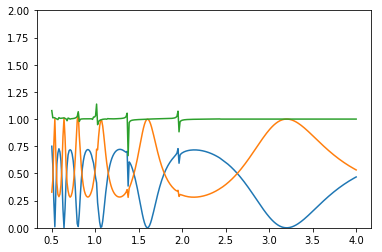

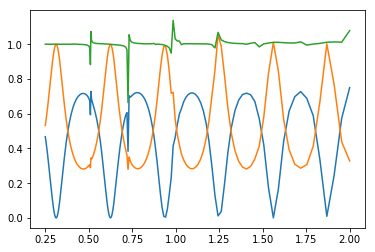

In [36]:
spectra = np.array(spectra);
spectra_T = np.array(spectra_T)
plt.figure();
plt.plot(wavelength_scan, spectra);
plt.plot(wavelength_scan, spectra_T)
plt.plot(wavelength_scan, spectra+spectra_T)
# plt.legend(['reflection', 'transmission'])
# plt.axhline(((3.48-1)/(3.48+1))**2,xmin=0, xmax = max(wavelength_scan))
# plt.axhline(((3.48-1)/(3.48+1)),xmin=0, xmax = max(wavelength_scan), color='r')
#
plt.ylim([0,2])
plt.show()

plt.figure();
plt.plot(1/wavelength_scan, spectra);
plt.plot(1/wavelength_scan, spectra_T)
plt.plot(1/wavelength_scan, spectra+spectra_T)
plt.show()

In [35]:
sorted_eigenvals.shape
sorted_eigenmodes.shape


(14, 7)